In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from pathlib import Path
from utils import *
from behavior_utils import *

### Set up paths

In [2]:
# Build paths
root_path = 'S:/'
experiment = 'clickbait-motivate'
session_type = 'm'

data_dir = os.path.join(root_path, experiment)
save_dir = os.path.join(root_path, experiment, "preprocessed")
gain = 0.1949999928474426

os.makedirs(save_dir, exist_ok=True)
open_ephys_dir = os.path.join(data_dir, "open-ephys")

### Get continuous.dat file paths

In [10]:
data_paths = get_file_paths(directory=open_ephys_dir, extension='dat', keyword='continuous', print_paths=True)

Found 56 continuous.dat files
0 S:\clickbait-motivate\open-ephys\m1_2025-10-08_13-18-56_7010\Record Node 113\experiment1\recording4\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
1 S:\clickbait-motivate\open-ephys\m1_2025-10-08_14-15-13_7011\Record Node 113\experiment1\recording1\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
2 S:\clickbait-motivate\open-ephys\m1_2025-10-08_15-08-37_7012\Record Node 113\experiment1\recording1\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
3 S:\clickbait-motivate\open-ephys\m1_2025-10-08_15-59-59_7013\Record Node 113\experiment1\recording1\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
4 S:\clickbait-motivate\open-ephys\m2_2025-10-09_11-01-00_7013\Record Node 113\experiment1\recording2\continuous\Acquisition_Board-112.acquisition_board\continuous.dat
5 S:\clickbait-motivate\open-ephys\m2_2025-10-09_11-58-36_7010\Record Node 113\experiment1\recording1\continuous\Acquisition_Board

In [11]:
# Extract session and mouse ids and build a dataframe for easy mkdir later
session_ids, mouse_ids = get_ids_from_path(data_paths)
data_df = pd.DataFrame({"session_id": session_ids, "mouse_id": mouse_ids, "continuous.dat": data_paths})
data_df.head()

session_id mouse_id                                     continuous.dat
0         m1     7010  S:\clickbait-motivate\open-ephys\m1_2025-10-08...
1         m1     7011  S:\clickbait-motivate\open-ephys\m1_2025-10-08...
2         m1     7012  S:\clickbait-motivate\open-ephys\m1_2025-10-08...
3         m1     7013  S:\clickbait-motivate\open-ephys\m1_2025-10-08...
4         m2     7013  S:\clickbait-motivate\open-ephys\m2_2025-10-09...

### Preprocess Open Ephys continuous.dat 

In [12]:
trode_ch = 32  # Number of tetrode channels
sniff_ch = -1  # Sniff ADC channel
ttl_ch = -2  # TTL ADC channel

for ii in range(4,5):  #len(data_df)
    print(f"{ii} Preprocessing {data_df['mouse_id'][ii]}-{data_df['session_id'][ii]} ({ii+1}/{len(data_df)})")
    
    # Making the data directory
    preprocessed_dir = os.path.join(save_dir, data_df['mouse_id'][ii], data_df['session_id'][ii])
    os.makedirs(preprocessed_dir, exist_ok=True)
    
    # Loading the data using memory mapping 
    data = np.memmap(data_df['continuous.dat'][ii], dtype=np.int16, mode='r')
    data = data.reshape((-1, 40), order='C').T  # Reshape to (40, n_samples)
    
    # ===== PROCESS EPHYS =====
    # Extract and process ephys channels one at a time
    ephys = np.empty((trode_ch, data.shape[1]), dtype=np.float32)  # Use float32 instead of float64
    ephys[:] = data[:trode_ch, :] * gain
    
    # Process ephys signal
    sos = signal.butter(4, [300, 6000], 'bandpass', fs=30000, output='sos')
    ephys = signal.sosfiltfilt(sos, ephys)
    
    # Median common average referencing within each region. Ch 1-16 in CA1, Ch 17-32 in OB.
    ephys[:trode_ch//2, :] -= np.median(ephys[:trode_ch//2, :], axis=0, keepdims=True)
    ephys[trode_ch//2:, :] -= np.median(ephys[trode_ch//2:, :], axis=0, keepdims=True)
    
    # Save MUA
    ephys = ephys.astype(np.int16)
    np.save(os.path.join(preprocessed_dir, 'mua.npy'), ephys)
    del ephys
    
    # ===== PROCESS SNIFF =====
    # Extract sniff channel directly without creating intermediate arrays
    sniff = data[sniff_ch, :].astype(np.float32)  # Use float32
    
    b, a = signal.iirnotch(60, 10, 30_000)
    sniff = signal.filtfilt(b, a, sniff)
    sos = signal.butter(3, 40, 'low', fs=30_000, output='sos')
    sniff = signal.sosfiltfilt(sos, sniff)
    sniff -= np.median(sniff)
    sniff = signal.decimate(sniff, 30)
    
    # Save sniff signal
    sniff = sniff.astype(np.int16)
    np.save(os.path.join(preprocessed_dir, 'sniff.npy'), sniff)
    del sniff
    
    # ===== PROCESS TTL =====
    ttl = data[ttl_ch, :].astype(np.float32)  # Use float32
    ttl = signal.decimate(ttl, 30)
    ttl_bool = ttl > 0.0
    del ttl 
    
    ttl_diffs = np.diff(ttl_bool.astype(np.int8))
    ttl_times = np.where(ttl_diffs == -1)[0]
    
    # Save TTLs
    ttl_times = ttl_times.astype(np.int32)
    np.save(os.path.join(preprocessed_dir, 'ttl_signal.npy'), ttl_bool)
    np.save(os.path.join(preprocessed_dir, 'ttl_times.npy'), ttl_times)
    del ttl_bool, ttl_diffs, ttl_times
    
    del data  # Clean up memmap

4 Preprocessing 7013-m2 (5/56)


In [20]:
ttl_paths = get_file_paths(data_dir, extension='npy', keyword='ttl_signal', print_paths=True)

Found 28 ttl_signal.npy files
0 S:\clickbait-motivate\preprocessed\7010\m1\ttl_signal.npy
1 S:\clickbait-motivate\preprocessed\7010\m2\ttl_signal.npy
2 S:\clickbait-motivate\preprocessed\7010\m3\ttl_signal.npy
3 S:\clickbait-motivate\preprocessed\7010\m4\ttl_signal.npy
4 S:\clickbait-motivate\preprocessed\7010\m5\ttl_signal.npy
5 S:\clickbait-motivate\preprocessed\7010\m6\ttl_signal.npy
6 S:\clickbait-motivate\preprocessed\7010\m7\ttl_signal.npy
7 S:\clickbait-motivate\preprocessed\7011\m1\ttl_signal.npy
8 S:\clickbait-motivate\preprocessed\7011\m2\ttl_signal.npy
9 S:\clickbait-motivate\preprocessed\7011\m3\ttl_signal.npy
10 S:\clickbait-motivate\preprocessed\7011\m4\ttl_signal.npy
11 S:\clickbait-motivate\preprocessed\7011\m5\ttl_signal.npy
12 S:\clickbait-motivate\preprocessed\7011\m6\ttl_signal.npy
13 S:\clickbait-motivate\preprocessed\7011\m7\ttl_signal.npy
14 S:\clickbait-motivate\preprocessed\7012\m1\ttl_signal.npy
15 S:\clickbait-motivate\preprocessed\7012\m2\ttl_signal.npy
16 S

In [7]:
ttl_test = np.load(ttl_paths[0])
ttl_test.shape

(2724400,)

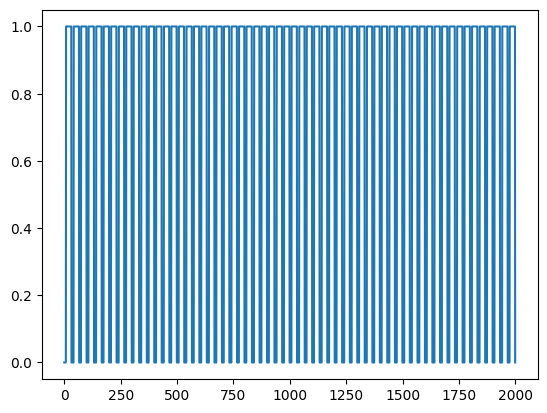

In [8]:
plt.plot(ttl_test[10000:12000])

TTL Preprocessing Test

In [9]:
ttl_paths = get_file_paths(directory=data_dir, extension='npy', keyword='ttl')
ttl_data = np.load(ttl_paths[0])

Found 54 ttl.npy files


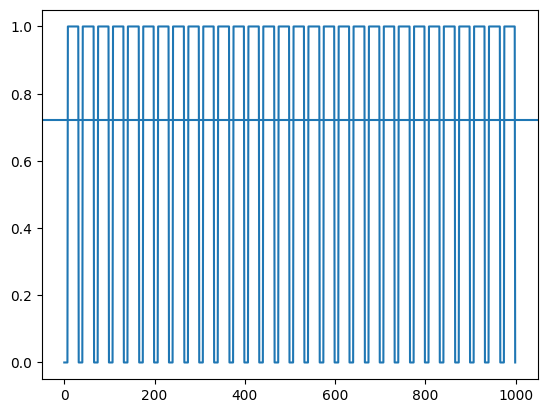

In [10]:
ttl_mean = np.mean(ttl_data)
plt.plot(ttl_data[50000:51000])
plt.axhline(ttl_mean)

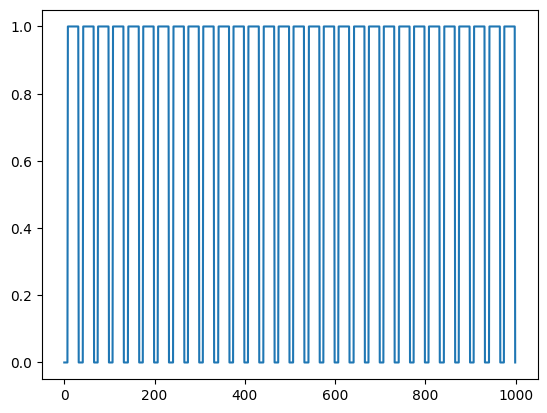

In [11]:
ttl_bool = ttl_data > 0.0
plt.plot(ttl_bool[10000:11000])

In [12]:
ttl_bool = ttl_data > float(0)
ttl_transition = -1
ttl_diffs = np.diff(ttl_bool.astype(np.int8))
ttl_frames = np.where(ttl_diffs == ttl_transition)[0]

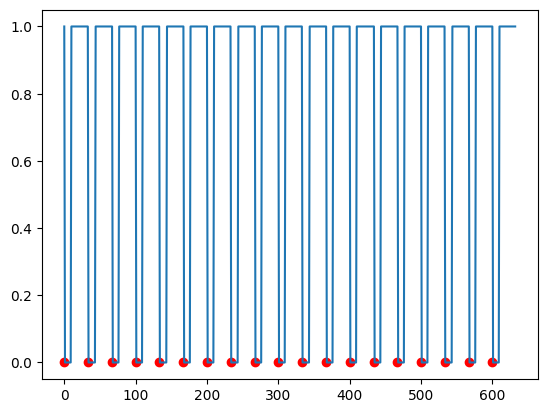

In [13]:
start = -20
stop = -1
plt.plot(ttl_bool[ttl_frames[start]:ttl_frames[stop]])
plt.scatter(ttl_frames[start:stop]-ttl_frames[start], np.zeros(len(ttl_frames[start:stop])), c='r')

In [14]:
len(ttl_frames)

81308

In [15]:
str(video_path[0])

NameError: name 'video_path' is not defined

In [135]:
import cv2
video_path = get_file_paths(directory = data_dir, extension='avi')
cap = cv2.VideoCapture(str(video_path[0]))

Found 1 .avi files


In [137]:
cap.get(cv2.CAP_PROP_FRAME_COUNT)

81825.0